# Análisis de importancia global de características

En este notebook, nos enfocaremos en la interpretabilidad del modelo en el sentido global, es decir, como es que el modelo decide el nivel de importancia que le da a las variables con las cuales fue entrenado, respecto a como decide cuando un registro es catalogado como frauduleno o no.

Para lograrlo, vamos a aplicar y visualizar técnicas de explicabilidad global para entender el comportamiento general del modelo de clasificación de fraude. Se implementarán las técnicas mencionadas en el problema original (Feature Permutation) y se complementarán con un análisis SHAP para una visión más profunda.

In [ ]:
# ====================================================================
# LIBRERÍAS
# ====================================================================
# Se importan las librerías necesarias para el análisis de explicabilidad global.
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.inspection import permutation_importance

# Configuraciones para una mejor visualización.
sns.set_style('whitegrid')
%matplotlib inline

c:\Users\death\OneDrive\Documentos\Proyectos\XAI_Exercise\credit_fraud\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Procedemos a cargar el modelo y los datos de entrenamiento y prueba usados en el notebook anterior, para usarlos en esta etapa:

In [2]:
# ====================================================================
# CARGA DE DATOS Y MODELO
# ====================================================================
# Se cargan el modelo entrenado y los conjuntos de datos necesarios.

# Cargar el modelo
MODEL_LOAD_PATH = "../Source/models/fraud_classifier.pkl"
with open(MODEL_LOAD_PATH, 'rb') as file:
    model = pickle.load(file)

# Cargar los datos
DATA_LOAD_PATH = "../Source/processed_data/split_data.pkl"
with open(DATA_LOAD_PATH, 'rb') as file:
    processed_data = pickle.load(file)

X_test = processed_data["X_test"]
y_test = processed_data["y_test"]

print("Modelo y datos cargados exitosamente.")

Modelo y datos cargados exitosamente.


## Técnica 1: Importancia de Features por Permutación (Feature Permutation)

Esta técnica mide la importancia de una característica calculando el decremento en el rendimiento del modelo después de permutar (barajar) aleatoriamente los valores de ésta. Si una variable es importante, barajar sus valores debería causar una caída significativa en la métrica de evaluación (ej. AUPRC o ROC AUC).

In [ ]:
# ====================================================================
# CÁLCULO DE LA IMPORTANCIA POR PERMUTACIÓN
# ====================================================================
# Se calcula la importancia de cada variable utilizando el conjunto de prueba.
# La métrica de scoring será 'roc_auc', ya que es sensible a la clasificación de la clase minoritaria.

print("Calculando la importancia por permutación...")
result = permutation_importance(
    model, 
    X_test, 
    y_test,
    n_repeats=10,        # Se repite 10 veces para obtener resultados más estables
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)
print("Cálculo completado.")

# Se organiza el resultado en un DataFrame de pandas para facilitar su visualización.
perm_importance = pd.DataFrame(
    {'feature': X_test.columns, 
     'importance_mean': result.importances_mean,
     'importance_std': result.importances_std}
).sort_values('importance_mean', ascending=False)

Calculando la importancia por permutación... (puede tardar unos minutos)
Cálculo completado.


In [4]:
perm_importance

,feature,importance_mean,importance_std
14,V15,0.005246,0.000014
28,Amount,0.004812,0.001528
19,V20,0.004809,0.001527
25,V26,0.003270,0.002486
20,V21,0.003236,0.002480
3,V4,0.003028,0.002548
2,V3,0.001302,0.002040
13,V14,0.000818,0.003958
16,V17,0.000765,0.000049
8,V9,0.000735,0.001528


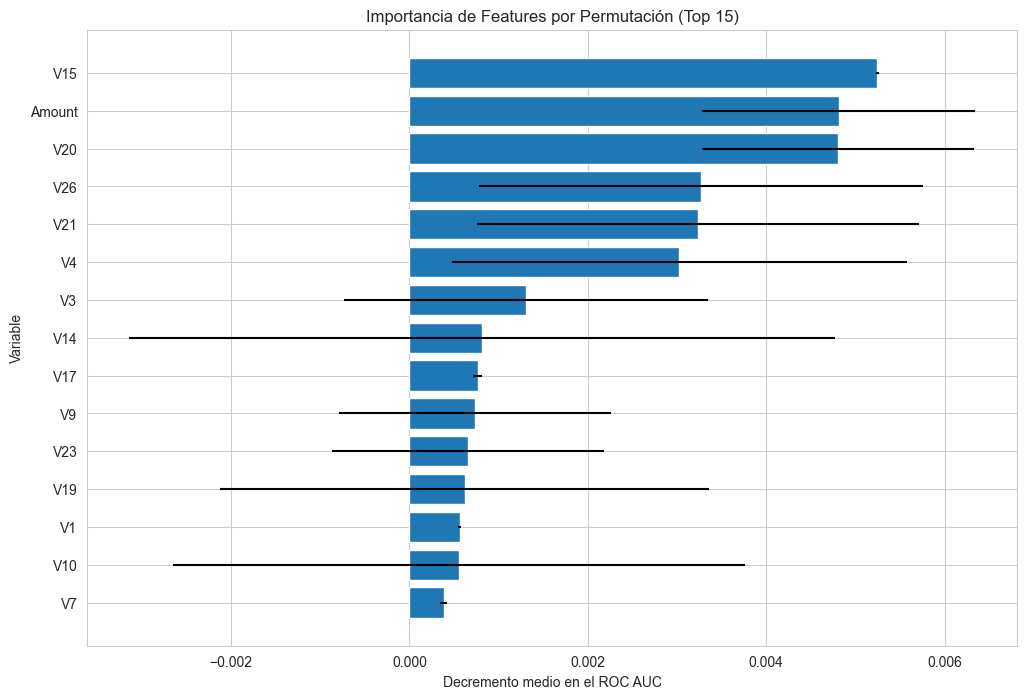

In [6]:
# ====================================================================
# VISUALIZACIÓN DE LA IMPORTANCIA POR PERMUTACIÓN
# ====================================================================
# Se muestran las 15 features más importantes.

plt.figure(figsize=(12, 8))
plt.barh(
    perm_importance['feature'][:15], 
    perm_importance['importance_mean'][:15], 
    xerr=perm_importance['importance_std'][:15],
    align='center'
)
plt.gca().invert_yaxis() # Mostrar la más importante arriba
plt.title('Importancia de Features por Permutación (Top 15)')
plt.xlabel('Decremento medio en el ROC AUC')
plt.ylabel('Variable')
plt.show()

Podemos observar gracias a la gráfica de arriba que las variables en la parte superior del gráfico son las más importantes, es decir, V15, Monto y V20, seguidas en menor medida por V26, V21 y V4. 

Este modelo depende en gran medida de dichas variables para hacer predicciones precisas.

## Técnica 2: Análisis Global con SHAP

Usemo ahora otro tipo de gráfico. El "SHAP Summary Plot" es la visualización estándar y más potente para la importancia global de características. Es superior a la permutación porque no solo muestra cuáles variables son importantes, sino cómo afectan a la predicción.

In [15]:
# ====================================================================
# CÁLCULO DE VALORES SHAP
# ====================================================================
# SHAP (SHapley Additive exPlanations) asigna a cada feature un valor de importancia 
# para cada predicción individual. Para obtener una visión global, podemos agregar estos valores.

# 1. Crear el explainer. Usamos TreeExplainer, optimizado para RandomForest.
explainer = shap.TreeExplainer(model)

# 2. Calcular los valores SHAP para el conjunto de prueba.
#    Usamos check_additivity=False para acelerar, no es crítico para este análisis.
print("Calculando valores SHAP...")
shap_values = explainer.shap_values(X_test)# explainer(X_test, check_additivity=False)
print("Cálculo de SHAP completado.")

Calculando valores SHAP...
Cálculo de SHAP completado.


In [16]:
shap_values

array([[[ 0.00479716, -0.00479716],
        [ 0.00092667, -0.00092667],
        [ 0.00886723, -0.00886723],
        ...,
        [-0.00041288,  0.00041288],
        [ 0.00222816, -0.00222816],
        [ 0.00790395, -0.00790395]],

       [[ 0.00316849, -0.00316849],
        [ 0.00846252, -0.00846252],
        [ 0.0798411 , -0.0798411 ],
        ...,
        [ 0.00422662, -0.00422662],
        [ 0.00714716, -0.00714716],
        [ 0.00643984, -0.00643984]],

       [[ 0.00677481, -0.00677481],
        [ 0.0038998 , -0.0038998 ],
        [ 0.09511427, -0.09511427],
        ...,
        [ 0.00542762, -0.00542762],
        [ 0.00320283, -0.00320283],
        [ 0.00934175, -0.00934175]],

       ...,

       [[ 0.00421108, -0.00421108],
        [ 0.00551332, -0.00551332],
        [ 0.04383542, -0.04383542],
        ...,
        [ 0.00337519, -0.00337519],
        [ 0.0020472 , -0.0020472 ],
        [ 0.00633046, -0.00633046]],

       [[ 0.03565061, -0.03565061],
        [ 0.00820835, -0.00

Generando SHAP Summary Plot...


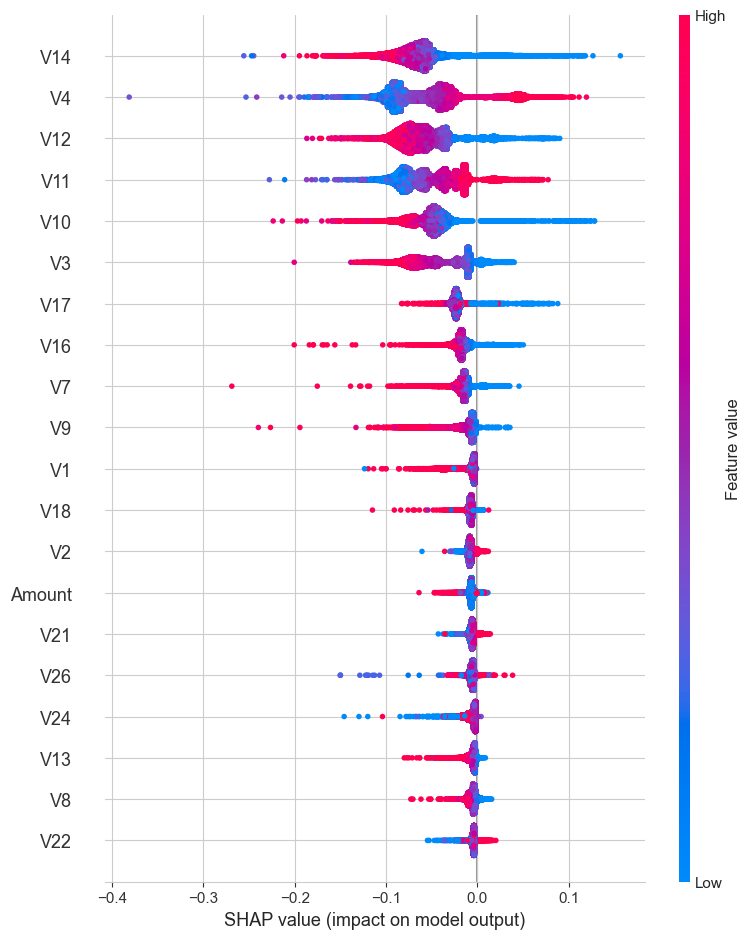

In [21]:
# ====================================================================
# VISUALIZACIÓN SHAP: SUMMARY PLOT (BEESWARM)
# ====================================================================
# Este gráfico es extremadamente rico en información. Cada punto es una instancia.
# - Eje Y: Features, ordenadas por importancia.
# - Eje X: Valor SHAP (el impacto en la predicción). Un valor > 0 empuja hacia "Fraude".
# - Color: Valor original de la feature (Rojo = alto, Azul = bajo).

print("Generando SHAP Summary Plot...")
plt.figure()
shap.summary_plot(shap_values[:,:,1], X_test, plot_type="dot") # Usamos los valores para la clase 1 (Fraude)
plt.show()

Podemos interpretar el gráfico recién renderado de la siguiente forma:

Cada punto del gráfico representa el valor SHAP que cada registro a lo largo de las variables (características) influye en la dirección y magnitud de la predicción final del modelo.

- Variable V14: Es la más importante. Valores BAJOS (azul) tienen un alto valor SHAP, empujando la predicción fuertemente hacia 'Fraude'
- Variable V12: La tercera más importante. Sus valores BAJOS (azul) también indican fuertemente 'Fraude'
- Variable V4: La que se encuentra en segundo lugar, a diferencia de las anteriores, sus valores ALTOS (rojo) de están asociados con fraude.

Como se puede observar, este enfoque nos da una mejor interpretabilidad en términos de que variables son las que impactan mayormente a las predicciones del modelo, a diferencia del Feature Permutation, en la que por ejemplo podemos inferir que la variable V14 sí impacta en las decisiones del modelo, sobre todo por su varianza, pero no es tan obvio a simple vista como lo es con SHAP. Otra diferencia importante a destacar es que la variable V12 en el gráfico de Feature Permutation ni siquera aparece en el top 15, mientras que en el gráfico de valores SHAP se ve claramente su influencia prioritaria.

## Guardado de Explicaciones y Visualizaciones

Guardamos los objetos y gráficos generados para usarlos más tarde en el reporte final.

In [22]:
# ====================================================================
# GUARDADO DE RESULTADOS GLOBALES
# ====================================================================
# Se guardan los datos de importancia y el objeto explainer para uso futuro.
import os

# Crear un directorio para los resultados si no existe.
os.makedirs('../Source/explainability_results', exist_ok=True)
os.makedirs('../visualizations', exist_ok=True)

# 1. Guardar el DataFrame de Permutation Importance.
perm_importance.to_csv('../Source/explainability_results/permutation_importance.csv', index=False)

# 2. Guardar el objeto explainer y los valores SHAP.
with open('../Source/explainability_results/shap_global_explainer.pkl', 'wb') as f:
    pickle.dump(explainer, f)
with open('../Source/explainability_results/shap_global_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)
    
print("Resultados de explicabilidad global guardados exitosamente.")


Resultados de explicabilidad global guardados exitosamente.
